<a href="https://colab.research.google.com/github/RymMehdi/Rym/blob/master/nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from tensorflow import keras
import nltk
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Definition of a plot function for training result visualization

In [3]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

Importing the data

In [4]:
train_data = pd.read_csv('./train.txt', delimiter = ';', header = None)
train_data.columns = ['comments', 'feeling']
test_data = pd.read_csv('./test.txt', delimiter=';', header=None)
test_data.columns = ['comments', 'feeling']
train_data.head()

,comments,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  16000 non-null  object
 1   feeling   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [6]:
test_data.head()

,comments,feeling
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  2000 non-null   object
 1   feeling   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


## ***preprocessing data***


**tokenization**

In [5]:
# Separate features and labels
X_train = train_data['comments']
y_train = train_data['feeling']

X_test = test_data['comments']
y_test = test_data['feeling']

train_size = len(X_train)
test_size = len(X_test)
batch_size = 32

In [6]:
# Tokenize the comments
X_train = [nltk.word_tokenize(comment) for comment in X_train]
X_test = [nltk.word_tokenize(comment) for comment in X_test]

# Initialize tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [7]:
# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences
max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)


In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [9]:
# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train_encoded))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test_encoded))
test_dataset = test_dataset.batch(32)


#**Models**

**1. A Fully Connected Neural Network**

In [10]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 50)            760550    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dense_1 (Dense)             (None, 300)               38700     
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 806,079
Trainable params: 806,079
Non-trainable params: 0
__________________________________________________

In [12]:
# Compile the model
tf.keras.backend.clear_session()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


In [16]:

# Train the model
history = model.fit(X_train_padded, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_test_padded, y_test_encoded), callbacks=[early])

Epoch 1/30
500/500 [==============================] - 15s 25ms/step - loss: -144117.0938 - accuracy: 0.1211 - val_loss: -770761.8125 - val_accuracy: 0.1120
Epoch 2/30
500/500 [==============================] - 7s 13ms/step - loss: -4915447.0000 - accuracy: 0.1211 - val_loss: -12615772.0000 - val_accuracy: 0.1120
Epoch 3/30
500/500 [==============================] - 7s 14ms/step - loss: -31491842.0000 - accuracy: 0.1211 - val_loss: -58329000.0000 - val_accuracy: 0.1120
Epoch 4/30
500/500 [==============================] - 7s 13ms/step - loss: -104594792.0000 - accuracy: 0.1211 - val_loss: -163216624.0000 - val_accuracy: 0.1120
Epoch 5/30
500/500 [==============================] - 7s 14ms/step - loss: -249617168.0000 - accuracy: 0.1211 - val_loss: -353133568.0000 - val_accuracy: 0.1120
Epoch 6/30
500/500 [==============================] - 7s 15ms/step - loss: -490921088.0000 - accuracy: 0.1211 - val_loss: -649974464.0000 - val_accuracy: 0.1120
Epoch 7/30
500/500 [========================

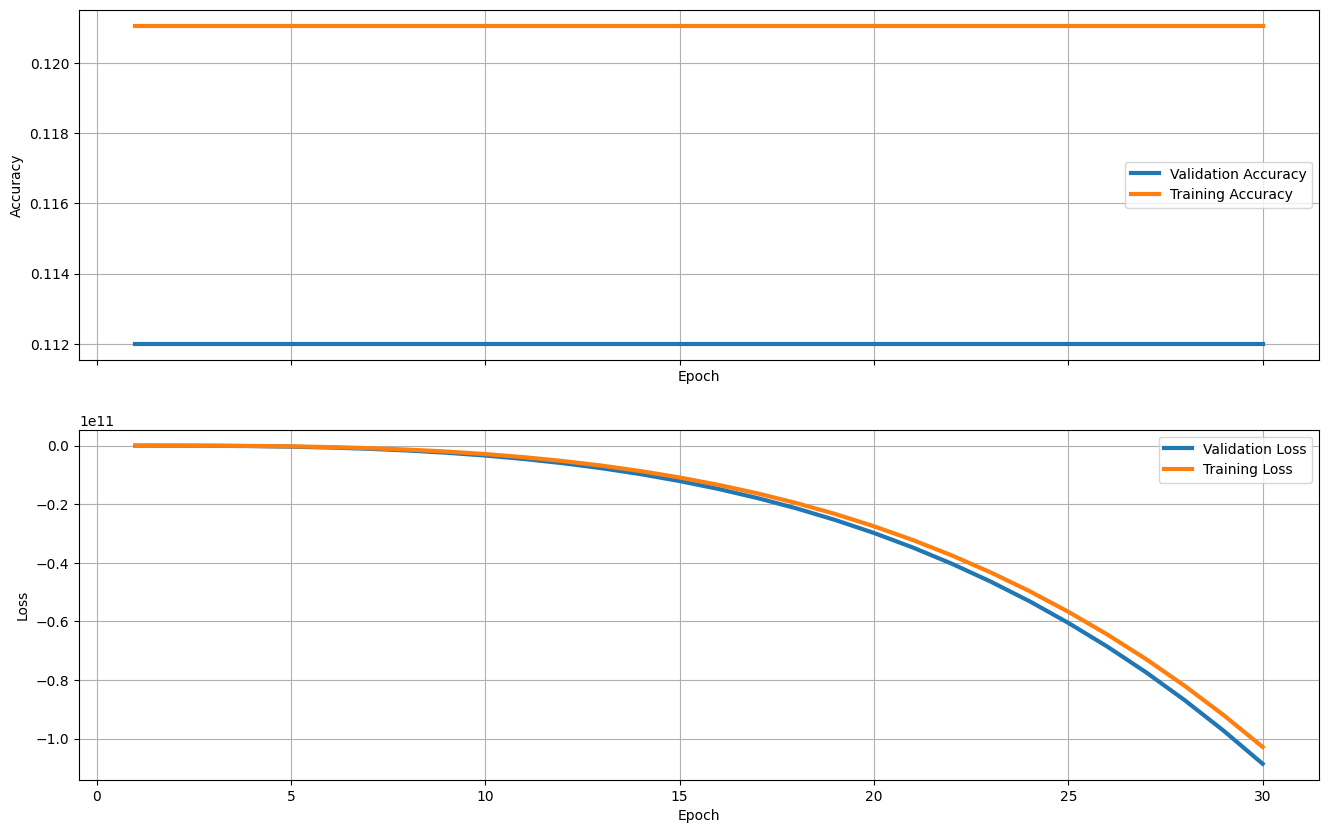

In [17]:
plot_results(history)

**2. A Recurrent Neural Network, based on GRU**

In [13]:
embedding_dim = 50

In [14]:
# Model definition with GRU
model_gru = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(GRU(32)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 50)            760550    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16128     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 777,075
Trainable params: 777,075
Non-trainable params: 0
_________________________________________________________________


In [15]:
tf.keras.backend.clear_session()

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_gru = model_gru.fit(X_train_padded, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_test_padded, y_test_encoded), callbacks=[early])


Epoch 1/30
500/500 [==============================] - 41s 73ms/step - loss: -90.7521 - accuracy: 0.1211 - val_loss: -197.0708 - val_accuracy: 0.1120
Epoch 2/30
500/500 [==============================] - 31s 63ms/step - loss: -362.9449 - accuracy: 0.1211 - val_loss: -554.9612 - val_accuracy: 0.1120
Epoch 3/30
500/500 [==============================] - 33s 65ms/step - loss: -810.1888 - accuracy: 0.1211 - val_loss: -1083.5629 - val_accuracy: 0.1120
Epoch 4/30
500/500 [==============================] - 33s 65ms/step - loss: -1421.0680 - accuracy: 0.1211 - val_loss: -1765.9891 - val_accuracy: 0.1120
Epoch 5/30
500/500 [==============================] - 35s 71ms/step - loss: -2177.6240 - accuracy: 0.1211 - val_loss: -2583.3606 - val_accuracy: 0.1120
Epoch 6/30
500/500 [==============================] - 35s 70ms/step - loss: -3063.8494 - accuracy: 0.1211 - val_loss: -3526.5969 - val_accuracy: 0.1120
Epoch 7/30
500/500 [==============================] - 36s 72ms/step - loss: -4070.8120 - accur

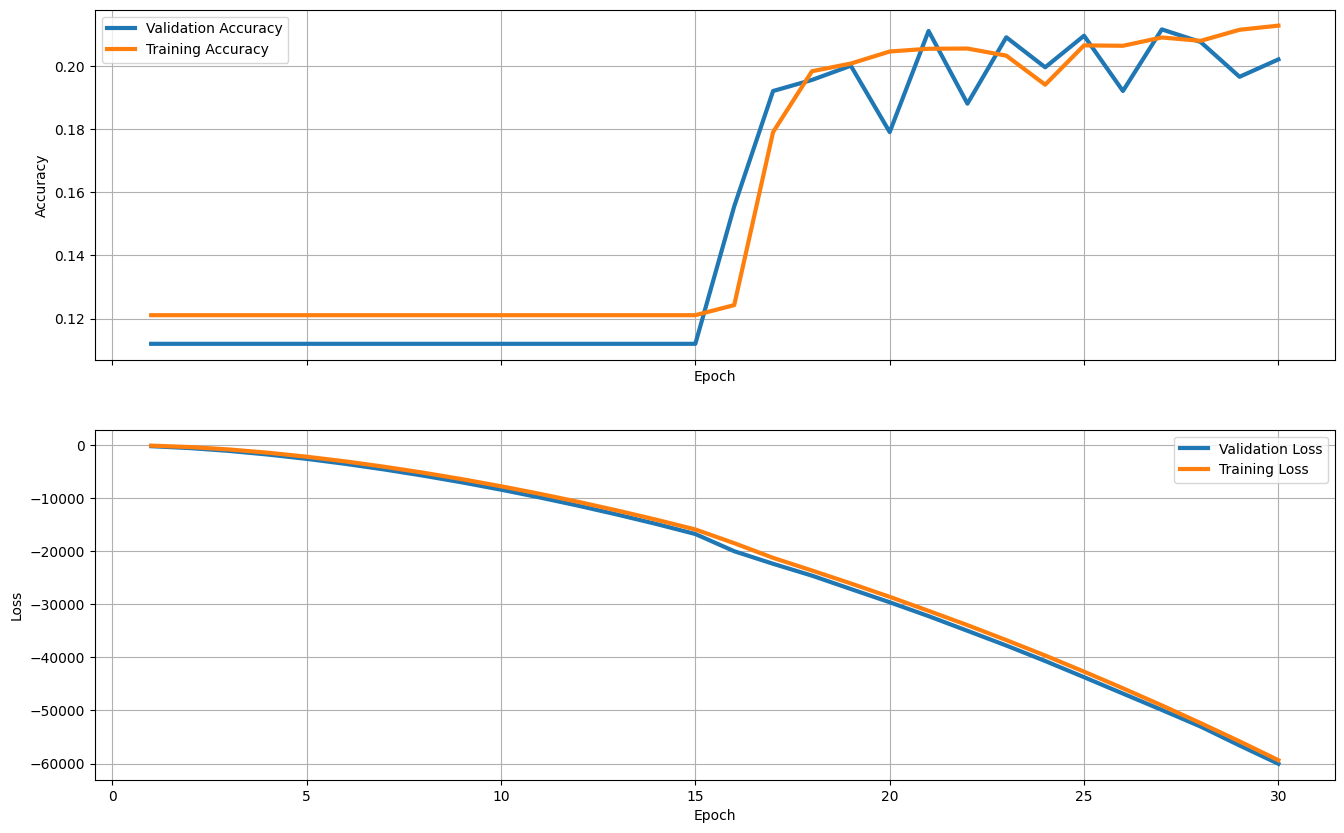

In [16]:
plot_results(history_gru)

3 A fine-tuned Transformer Architecture from a pretrained model

In [18]:
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, 100, input_length=max_len))
model3.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model3.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model3.add(tf.keras.layers.Dense(64, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(8, activation='softmax'))

model3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1521100   
                                                                 
 conv1d (Conv1D)             (None, 62, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0

In [19]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history_model3 = model3.fit(X_train_padded, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_test_padded, y_test_encoded), callbacks=[early])


Epoch 1/30
500/500 [==============================] - 44s 79ms/step - loss: 1.2435 - accuracy: 0.5227 - val_loss: 0.6496 - val_accuracy: 0.7650
Epoch 2/30
500/500 [==============================] - 39s 79ms/step - loss: 0.5171 - accuracy: 0.8146 - val_loss: 0.5778 - val_accuracy: 0.7830
Epoch 3/30
500/500 [==============================] - 39s 79ms/step - loss: 0.3737 - accuracy: 0.8664 - val_loss: 0.6430 - val_accuracy: 0.7765
Epoch 4/30
500/500 [==============================] - 39s 78ms/step - loss: 0.2854 - accuracy: 0.8972 - val_loss: 0.7218 - val_accuracy: 0.7805
Epoch 5/30
500/500 [==============================] - 40s 80ms/step - loss: 0.2320 - accuracy: 0.9156 - val_loss: 0.7305 - val_accuracy: 0.7735
Epoch 6/30
500/500 [==============================] - 40s 79ms/step - loss: 0.1974 - accuracy: 0.9279 - val_loss: 0.8518 - val_accuracy: 0.7720
Epoch 7/30
500/500 [==============================] - 39s 78ms/step - loss: 0.1774 - accuracy: 0.9333 - val_loss: 0.8725 - val_accuracy:

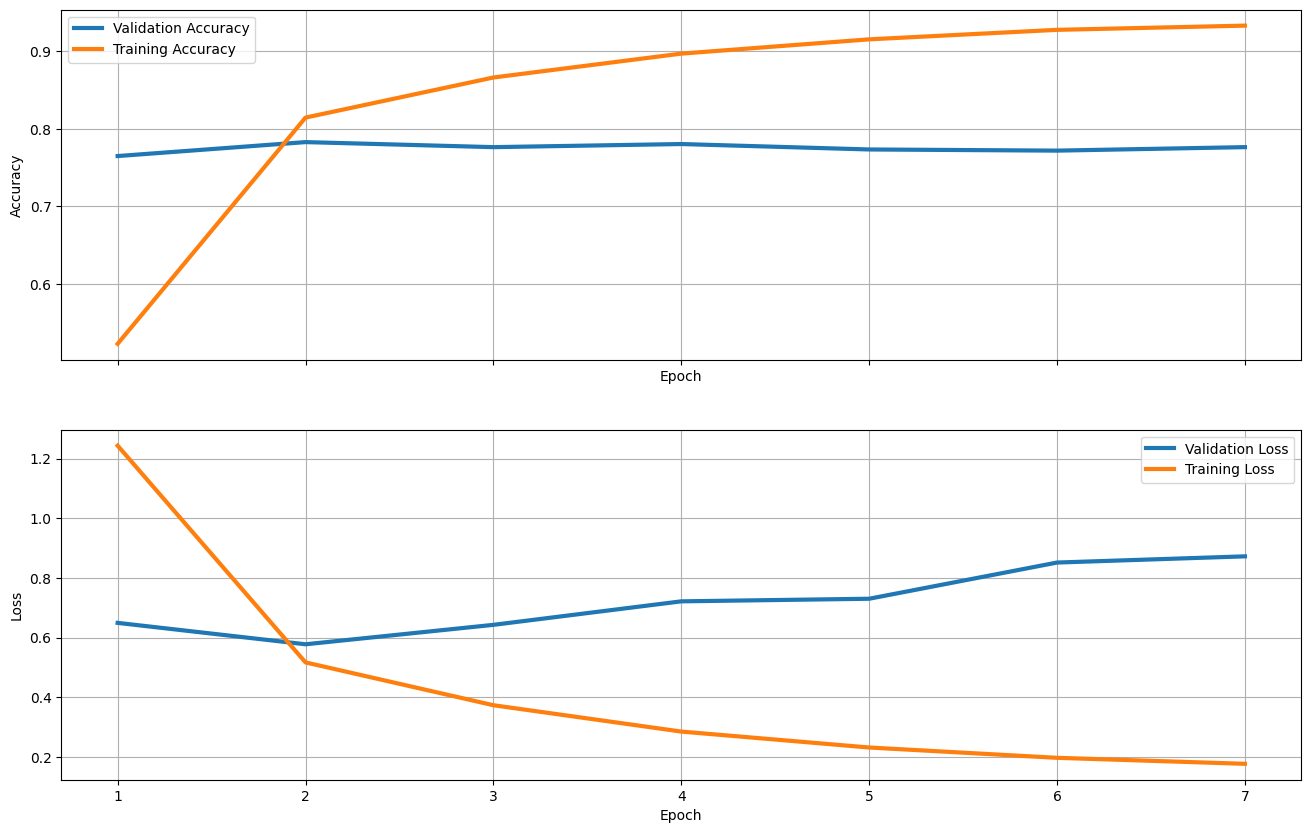

In [20]:
plot_results(history_model3)

# **Evaluation of  3 models**

**4.Compare the different models to find the best approach and try to duplicate it on a “real life”
text classification approach (this new “real life” dataset will be given to you soon)**

In [26]:
# Evaluate the model on the test dataset
results = model.evaluate(X_test_padded, y_test_encoded)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

63/63 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.1370
Test Loss: 0.6970406770706177
Test Accuracy: 0.13699999451637268


In [25]:
# Evaluate the model on the test dataset
results = model_gru.evaluate(X_test_padded, y_test_encoded)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

63/63 [==============================] - 1s 16ms/step - loss: -60050.7109 - accuracy: 0.2020
Test Loss: -60050.7109375
Test Accuracy: 0.20200000703334808


In [23]:
# Evaluate the model on the test dataset
results = model3.evaluate(X_test_padded, y_test_encoded)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

63/63 [==============================] - 2s 25ms/step - loss: 0.5778 - accuracy: 0.7830
Test Loss: 0.5778476595878601
Test Accuracy: 0.7829999923706055


The best model is the thirds one because he has the highest accuracy